It has been suggested by Nick that I can compute a Fischer Forecast with the VDF by just doing finite different around each point in the parameter space. Gonna try to do that here. 

In [147]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
#sns.set()

In [148]:
from pearce.emulator import LemonPepperWet, NashvilleHot
import numpy as np
from os import path
import h5py
from copy import deepcopy
from scipy.linalg import inv

In [149]:
fd_vals= np.load('/u/ki/swmclau2/Git/pearce/bin/vdf_fischer/fd_vals.npy')

In [150]:
fd_vals.shape

(7, 5, 2, 5, 20)

In [151]:
fiducial_hod = {'sigma_logM':0.2, 'logM0': 13.0, 'logM1': 14.0,
                'alpha':1.0,'conc_gal_bias': 1.0,\
                'mean_occupation_centrals_assembias_param1': 0.0,
               'mean_occupation_satellites_assembias_param1': 0.0}

In [152]:
pnames = ['mean_occupation_centrals_assembias_param1',
 'logM0',
 'sigma_logM',
 'mean_occupation_satellites_assembias_param1',
 'logM1',
 'alpha',
 'conc_gal_bias']

In [153]:
pbounds = [(-1.0, 1.0),
 (12.6, 13.6),
 (0.05, 0.5),
 (-1.0, 1.0),
 (13.7, 14.7),
 (0.7, 1.3),
 (0.5, 2.0)]

In [154]:
rbc = np.array([ 0.57715889,  0.7521343 ,  0.98015643,  1.27730729,  1.66454443,
        2.16917901,  2.82680202,  3.68379447,  4.80059857,  6.25598058,
        8.15258606, 10.62417931, 13.84507753, 18.04244507, 23.51231502,
       30.64046783, 39.92963975, 52.03497999, 67.81025724, 88.36807447])

In [155]:
rmin = 0.0
bin_idxs = np.where(rbc>rmin)[0]
rbc = rbc[bin_idxs]

In [156]:
fd_vals = fd_vals[:,:,:,:, bin_idxs]

In [157]:
fd_xi = fd_vals[:,0]
fd_1nn = fd_vals[:, 1]
fd_2nn = fd_vals[:, 2]
fd_4nn = fd_vals[:, 3]
fd_8nn = fd_vals[:, 4]

In [158]:
fd_xi.shape

(7, 2, 5, 20)

In [159]:
step_sizes = np.zeros((len(pnames), ))
for i, (name, bound) in enumerate(zip(pnames, pbounds)):
    hod = deepcopy(fiducial_hod)
    step_size = (bound[1]-bound[0])/10
    vals = (hod[name]-step_size, hod[name]+step_size)
    step_sizes[i] = step_size

In [160]:
def deriv(fd_vals, step_sizes):
    avg_vals = fd_vals.mean(axis=2)
    deriv = (avg_vals[:, 1] - avg_vals[:,0]).T/(2*step_sizes)
    return deriv.T

In [161]:
d_xi = deriv(fd_xi, step_sizes)
d_1nn = deriv(fd_1nn, step_sizes)
d_2nn = deriv(fd_2nn, step_sizes)
d_4nn = deriv(fd_4nn, step_sizes)
d_8nn = deriv(fd_8nn, step_sizes)

In [162]:
fd_vals_mean = fd_vals.mean(axis=(0,2,3))
mean_xi = fd_vals_mean[0]
mean_1nn = fd_vals_mean[1]
mean_2nn = fd_vals_mean[2]
mean_4nn = fd_vals_mean[3]
mean_8nn = fd_vals_mean[4]

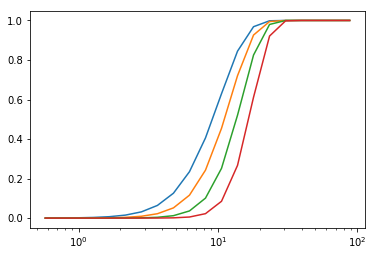

In [163]:
plt.plot(rbc, mean_1nn)
plt.plot(rbc, mean_2nn)
plt.plot(rbc, mean_4nn)
plt.plot(rbc, mean_8nn)
#plt.loglog();
plt.xscale('log')
#plt.yscale('log')

In [164]:
d_list = [d_xi, d_1nn, d_2nn, d_4nn, d_8nn]
mean_list = [mean_xi, mean_1nn, mean_2nn, mean_4nn, mean_8nn]

In [165]:
pnames

['mean_occupation_centrals_assembias_param1',
 'logM0',
 'sigma_logM',
 'mean_occupation_satellites_assembias_param1',
 'logM1',
 'alpha',
 'conc_gal_bias']

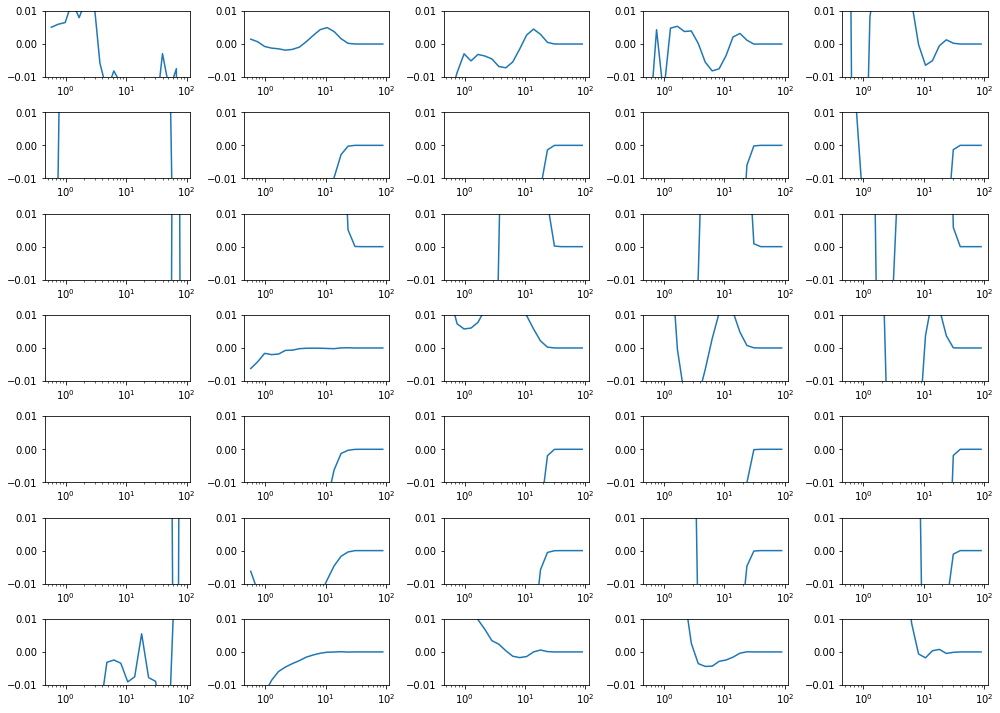

In [166]:
#fig = plt.figure(figsize=(17,6))
fig, axes = plt.subplots(len(pnames), 5, figsize = (len(pnames)*2, 5*2))
for i, name in enumerate(pnames):
    for j, (obs_name, d_obs, obs_mean) in enumerate(zip(['xi','1NN','2NN','4NN','8NN'],\
                                       d_list, mean_list)):
        ax = axes[i][j]
        #ax.set_title(name+' '+obs_name)
        ax.plot(rbc, d_obs[i]/obs_mean)
        ax.set_xscale('log')
        ax.set_ylim([-0.01, 0.01])
        #plt.xlabel('r [Mpc/h]')
plt.tight_layout()
plt.show()

In [167]:
def cholesky_inv(covmat):
    c = inv(cholesky(vdf_fischer_mat))
    return np.dot(c.T, c)

In [168]:
all_covmats = np.zeros((5, len(rbc), len(rbc)))
fudge_val = 0.0#1e-10
xi_covmat = np.load('/u/ki/swmclau2/Git/pearce/bin/covmat/xi_sim_fid_covmat.npy')[bin_idxs][:, bin_idxs]\
    +np.diag(np.ones(len(rbc))*fudge_val)#[:2][:,:2]
all_covmats[0] = xi_covmat

for i,n in enumerate([1,2,4,8]):
    all_covmats[i+1] = np.load('/u/ki/swmclau2/Git/pearce/bin/covmat/knn_%d_cdf_sim_fid_covmat.npy'%n)[bin_idxs][:, bin_idxs]\
              +np.diag(np.ones(len(rbc))*fudge_val)

#vdf_covmat+=np.diag(np.ones(vdf_covmat.shape[0]))*1e-3
#xi_covmat-=np.diag(np.ones(xi_covmat.shape[0]))*1e-12

In [169]:
inv_covmats = np.zeros_like(all_covmats)

for i, covmat in enumerate(all_covmats):
    print i
    print np.diag(covmat)
    inv_covmats[i] = inv(covmat)

0
[2.10286055e+01 7.90491863e+00 2.48278305e+00 6.46506808e-01
 1.76747846e-01 4.19336666e-02 9.59353694e-03 2.36640597e-03
 9.17720481e-04 4.04274648e-04 1.79752157e-04 9.68033342e-05
 5.66231799e-05 3.02307583e-05 1.86541592e-05 1.13037443e-05
 6.92330610e-06 4.55213384e-06 2.69194576e-06 1.52634594e-06]
1
[1.57706817e-12 3.15883177e-12 1.12641951e-11 5.93725159e-11
 3.03286871e-10 1.51001688e-09 6.94684708e-09 2.92773804e-08
 1.10245616e-07 3.53068095e-07 8.97369490e-07 1.57049712e-06
 1.48946559e-06 4.72855574e-07 3.21887944e-08 2.46211214e-09
 4.68584265e-10 2.56056182e-11 1.00000003e-12 1.00000000e-12]
2
[1.13211628e-12 1.63158523e-12 4.14078538e-12 1.61666462e-11
 6.61168369e-11 2.53044459e-10 8.42316627e-10 2.42487147e-09
 7.41541863e-09 3.55155124e-08 2.07370697e-07 8.54771309e-07
 1.78360691e-06 1.17800881e-06 1.22897283e-07 3.92218165e-09
 6.15940214e-10 3.77673397e-11 1.00007427e-12 1.00000000e-12]
3
[1.00304884e-12 1.01660000e-12 1.11992329e-12 1.86811920e-12
 6.89019864e-

In [170]:
def cov_to_corr(cov):
    std = np.sqrt(np.diag(cov))
    denom = np.outer(std, std)
    return cov/denom

97770627.64741623


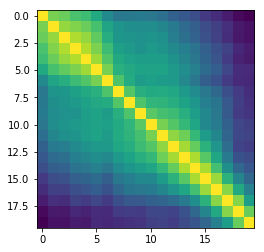

4590775.993841297


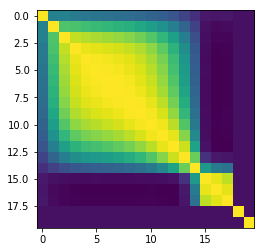

3804853.227850667


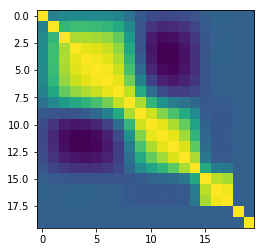

3878746.056988866


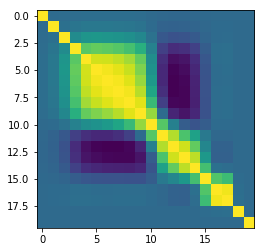

4051244.674378708


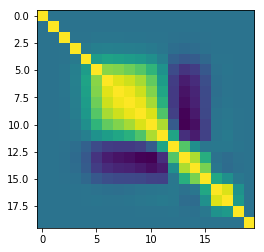

In [171]:
from numpy.linalg import cond 
for i, covmat in enumerate(all_covmats):
    print cond(covmat)#, cond(cov_to_corr(covmat))
    plt.imshow(cov_to_corr(covmat))
    plt.show()

In [172]:
d_1nn.shape

(7, 20)

In [173]:
all_info_mats = np.zeros((all_covmats.shape[0], d_1nn.shape[0], d_1nn.shape[0]))
d_vector = [d_xi, d_1nn, d_2nn, d_4nn, d_8nn]
for i, (inv_cov, d) in enumerate(zip(inv_covmats, \
                                     d_vector)):
    fischer_mat = np.dot(d, np.dot(inv_cov, d.T))
    fischer_mat+=np.diag(np.ones((fischer_mat.shape[0])))*1e-8
    all_info_mats[i] = inv(fischer_mat)

In [174]:
# joint constraint
from scipy.linalg import block_diag
d_all = np.hstack(d_vector[1:])
full_covmat = block_diag(*[cov for cov in all_covmats[1:]])# + np.diag(np.ones(vdf_covmat.shape[0]*3,))*1e-11
#full_covmat = block_diag(vdf_covmat, dvdf_covmat) + np.diag(np.ones(40,))*1e-11

full_fischer_mat = np.dot(d_all, np.dot(inv(full_covmat), d_all.T))
full_fischer_mat+=np.diag(np.ones((full_fischer_mat.shape[0])))*1e-8

full_nn_info_mat = inv(full_fischer_mat)

In [175]:
# joint constraint
from scipy.linalg import block_diag
d_all = np.hstack(d_vector)
full_covmat = block_diag(*[cov for cov in all_covmats])# + np.diag(np.ones(vdf_covmat.shape[0]*3,))*1e-11
#full_covmat = block_diag(vdf_covmat, dvdf_covmat) + np.diag(np.ones(40,))*1e-11

full_fischer_mat = np.dot(d_all, np.dot(inv(full_covmat), d_all.T))

full_fischer_mat+=np.diag(np.ones((full_fischer_mat.shape[0])))*1e-8

full_info_mat = inv(full_fischer_mat)

In [176]:
# joint constraint xi+1nn
from scipy.linalg import block_diag
d_all = np.hstack(d_vector[:2])
joint_covmat = block_diag(*[cov for cov in all_covmats[:2]])# + np.diag(np.ones(vdf_covmat.shape[0]*3,))*1e-11
#full_covmat = block_diag(vdf_covmat, dvdf_covmat) + np.diag(np.ones(40,))*1e-11

joint_fischer_mat = np.dot(d_all, np.dot(inv(joint_covmat), d_all.T))

joint_fischer_mat+=np.diag(np.ones((joint_fischer_mat.shape[0])))*1e-8

joint_info_mat = inv(joint_fischer_mat)

In [177]:
pnames

['mean_occupation_centrals_assembias_param1',
 'logM0',
 'sigma_logM',
 'mean_occupation_satellites_assembias_param1',
 'logM1',
 'alpha',
 'conc_gal_bias']

In [178]:
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

def ellipse_plot(inv_fisher, mean_x, mean_y, xname, yname, fig, ax, lab, co, scale=False):
    #alpha paramaters for 1 and 2 sigma contours
    #alpha1 = 1.52
    #alpha2 = 2.48
    #extracting relevant params from the input inverse fisher matrix
    sigma_x2 = inv_fisher[0][0]
    sigma_y2 = inv_fisher[1][1]
    sigma_xy = inv_fisher[0][1]
    
    pearson = sigma_xy/np.sqrt(sigma_y2 * sigma_x2)
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    a2 = 2*np.sqrt(1 + pearson)
    b2 = 2*np.sqrt(1 - pearson)
    
    
    #plotting 1 and 2 sigma contours
    #print mean_x, mean_y
    ell = Ellipse(xy = [0, 0], height = np.sqrt(b2), width = np.sqrt(a2), alpha=0.5, fill=True, label=lab, color=co)
    ell2 = Ellipse(xy = [0,0], height = np.sqrt(b2), width = np.sqrt(a2), alpha=0.35, fill=True,  color=co)

    scales = np.sqrt(np.diag(inv_fisher)) #* n_std


    transf1 = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scales[0], scales[1]).translate(mean_x, mean_y) \
        
    transf2 = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scales[0]*2, scales[1]*2).translate(mean_x, mean_y) \
        
    ell.set_transform(transf1 + ax.transData)
    ell2.set_transform(transf2 + ax.transData)

    #adding patches, axis names, etc
    #ax.add_patch(ell)
    ax.add_patch(ell2)
    #ax.set_aspect('equal')
    if scale:
        #ax.autoscale()
        n = 3

        sx, sy = np.sqrt(sigma_x2), np.sqrt(sigma_y2)
        ax.set_xlim([mean_x-n*sx, mean_x+n*sx])
        ax.set_ylim([mean_y-n*sy, mean_y+n*sy])
        if xname =='mean_occupation_centrals_assembias_param1':
            xname = 'A_cen'
        elif xname == 'mean_occupation_satellites_assembias_param1':
            xname = 'A_sat'
            
        if yname =='mean_occupation_centrals_assembias_param1':
            yname = 'A_cen'
        elif yname == 'mean_occupation_satellites_assembias_param1':
            yname = 'A_sat'
            
        ax.set_xlabel(xname)
        ax.set_ylabel(yname)

In [179]:
from scipy.stats import norm

In [180]:
param_name_dict = {'ombh2': r'$\Omega_b h^2$', 'omch2': r'$\Omega_c h^2$','w0': r'$w_0$','ns': r'$n_s$', \
                   'sigma8': r'$\sigma_8$', 'ln10As':r'$\ln 10^{10} A_s$', 'H0': r'$H_0$','Neff': r'$N_{eff}$',\
               'mean_occupation_centrals_assembias_corr1': r'$\rho_{cen}$',\
                 'mean_occupation_satellites_assembias_corr1':r'$\rho_{sat}$',\
                   'mean_occupation_centrals_assembias_param1': r'$\mathcal{A}_{cen}$',\
                 'mean_occupation_satellites_assembias_param1':r'$\mathcal{A}_{sat}$',\
                   'mean_occupation_centrals_assembias_slope1': r'$\mathcal{B}_{cen}$',\
                 'mean_occupation_satellites_assembias_slope1':r'$\mathcal{B}_{sat}$',\
                   'logM1': r'$\log(M_1)$','logM0': r'$\log(M_0)$',
                   'sigma_logM': r'$\sigma_{\logM}$',
                   'conc_gal_bias': r'$\eta$', 'alpha':r'$\alpha$',
                  'Om': r'$\Omega_m$', 'S8': r'$S_8$'}

In [181]:
bounds_dict = { 'alpha': (0.7, 1.3),
 'conc_gal_bias': (0.5, 1.5),
 'logM0': (12.6, 13.4),
 'logM1': (13.7, 14.3),
 'sigma_logM': (0.0, 0.4),
 'mean_occupation_centrals_assembias_param1': (-1.0, 1.0),
 'mean_occupation_satellites_assembias_param1': (-1.0, 1.0)}

In [182]:
plot_pnames = [param_name_dict[p] for p in pnames]
plot_pbounds = [bounds_dict[p] for p in pnames]

In [183]:
plot_pnames

['$\\mathcal{A}_{cen}$',
 '$\\log(M_0)$',
 '$\\sigma_{\\logM}$',
 '$\\mathcal{A}_{sat}$',
 '$\\log(M_1)$',
 '$\\alpha$',
 '$\\eta$']

In [184]:
reorder_idxs = [2,1,4,5,6,0,3]
plot_pnames_reorder = [plot_pnames[idx] for idx in reorder_idxs]
plot_pbounds_reorder = [plot_pbounds[idx] for idx in reorder_idxs]

In [185]:
plot_pnames_reorder

['$\\sigma_{\\logM}$',
 '$\\log(M_0)$',
 '$\\log(M_1)$',
 '$\\alpha$',
 '$\\eta$',
 '$\\mathcal{A}_{cen}$',
 '$\\mathcal{A}_{sat}$']

In [186]:
plot_pnames

['$\\mathcal{A}_{cen}$',
 '$\\log(M_0)$',
 '$\\sigma_{\\logM}$',
 '$\\mathcal{A}_{sat}$',
 '$\\log(M_1)$',
 '$\\alpha$',
 '$\\eta$']

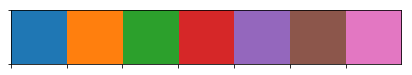

In [187]:
palette_idxs = [0,1,2,3,4,5,6]

palette = [sns.color_palette()[i] for i in palette_idxs]    
sns.palplot(palette)

In [188]:
from getdist import plots#, MCSamples

from getdist.gaussian_mixtures import GaussianND

mean = np.array([fiducial_hod[p] for p in pnames])
param_labels = [r'$\xi_{gg}$', '1-NN', '2-NN', '4-NN', '8-NN',\
                'Joint NN',r'$\xi_{gg}$+ 1-NN' ]
colors = palette

<Figure size 600x400 with 0 Axes>

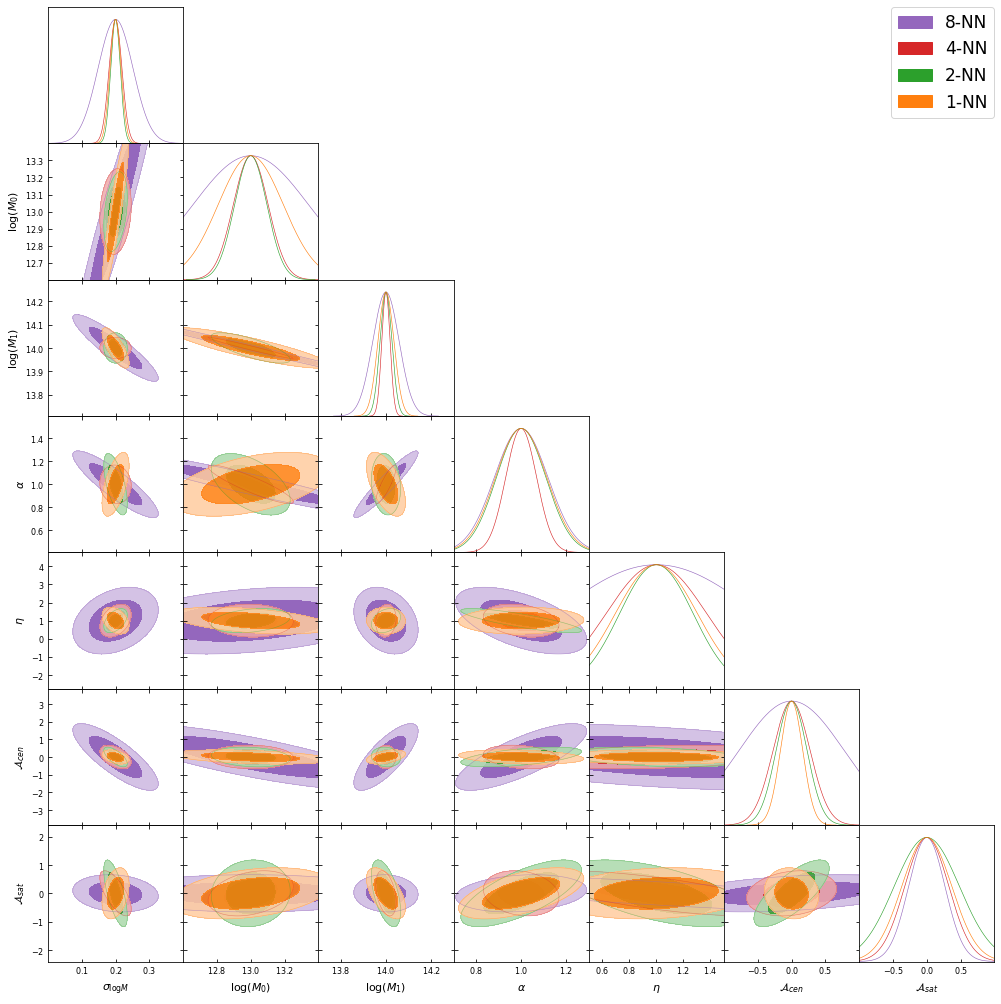

In [189]:
# All nns individually
fig = plt.figure()
start_idx, stop_idx = 1,5
dists = []
for info_mat in reversed(all_info_mats[start_idx:stop_idx]):
    dists.append(GaussianND(mean, info_mat, names=plot_pnames))
    
g = plots.get_subplot_plotter()
g.settings.legend_fontsize = 20

g.triangle_plot(dists,params=plot_pnames_reorder, legend_loc='upper right',\
                legend_labels=[p for p in reversed(param_labels[start_idx:stop_idx])],
                filled=True,colors = [c for c in reversed(colors[start_idx:stop_idx])],
            line_args=[{'color':c} for c in reversed(colors[start_idx:stop_idx])],
               param_limits=dict(zip(plot_pnames_reorder, plot_pbounds_reorder)));
g.fig.savefig('nn_fischer.pdf', format='pdf', bbox_inches='tight')

In [190]:
aim = [m for m in all_info_mats]
aim.append(full_nn_info_mat)
aim.append(joint_info_mat)

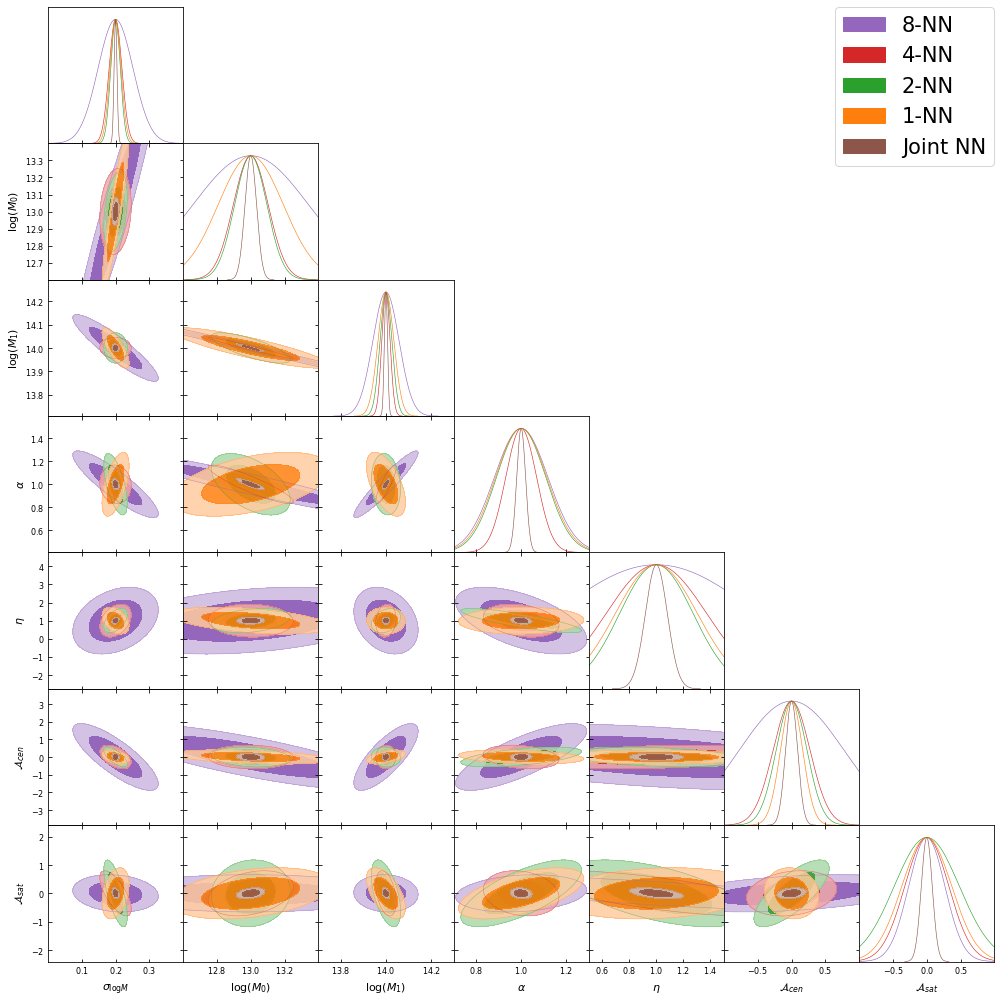

In [191]:
# All nns individually
idxs = np.array([4,3,2,1,5])
dists = []
for info_mat_idx in idxs:
    info_mat = aim[info_mat_idx]
    dists.append(GaussianND(mean, info_mat, names=plot_pnames))
    

labels = [param_labels[i] for i in idxs]
pcolors = [colors[i] for i in idxs]
#dists.append(GaussianND(mean, full_nn_info_mat, names=plot_pnames))
#labels.append('Joint NN')
#pcolors.append('k')

g = plots.get_subplot_plotter()
g.settings.legend_fontsize = 24

g.triangle_plot(dists,params=plot_pnames_reorder, legend_loc='upper right',\
                legend_labels=labels,
                filled=True,colors = pcolors,
            line_args=[{'color':c} for c in pcolors],
               param_limits=dict(zip(plot_pnames_reorder, plot_pbounds_reorder)));
g.fig.savefig('nn_joint_fischer.pdf', format='pdf', bbox_inches='tight')

 /u/ki/swmclau2/.local/lib/python2.7/site-packages/matplotlib/figure.py:457: UserWarning:matplotlib is currently using a non-GUI backend, so cannot show the figure


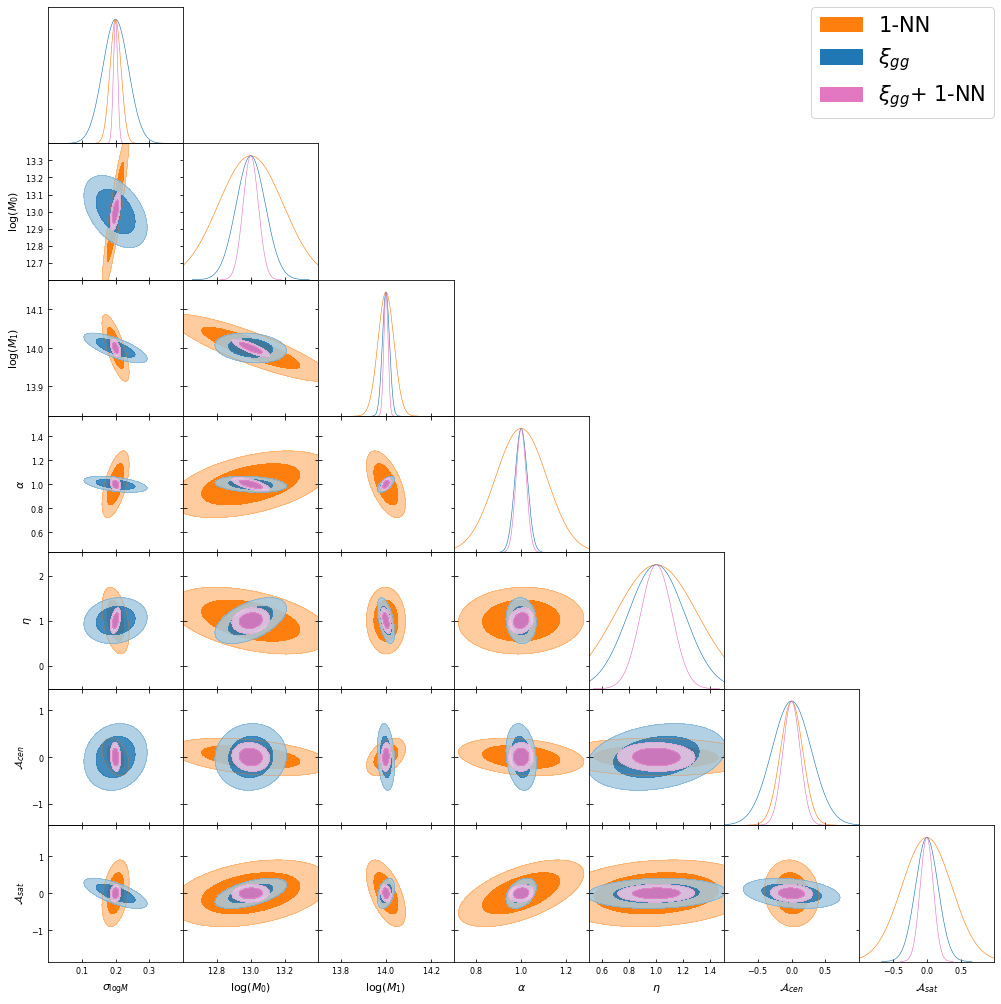

In [193]:
# xi vs. 1nn
idxs = np.array([1,0,6])
dists = []
for info_mat_idx in idxs:
    info_mat = aim[info_mat_idx]
    dists.append(GaussianND(mean, info_mat, names=plot_pnames))
    

labels = [param_labels[i] for i in idxs]
pcolors = [colors[i] for i in idxs]
#dists.append(GaussianND(mean, full_nn_info_mat, names=plot_pnames))
#labels.append('Joint NN')
#pcolors.append('k')

    
g = plots.get_subplot_plotter()
g.settings.legend_fontsize = 24

g.triangle_plot(dists,params=plot_pnames_reorder,legend_loc='upper right',\
                legend_labels=labels,
                filled=True, colors = pcolors,
                line_args=[{'color':c} for c in pcolors],
                param_limits=dict(zip(plot_pnames_reorder, plot_pbounds_reorder)));
g.fig.savefig('xi_vs_1nn_fischer.pdf', format='pdf', bbox_inches='tight')
fig.show();

In [ ]:
N = 2#d_vector[0].shape[0]
size = N*5

fig, axes = plt.subplots(ncols=N, nrows=N, figsize=((size,size)), facecolor='w')

for i, name1 in enumerate([pnames[0],pnames[3]]):
    for j, name2 in enumerate([pnames[0],pnames[3]]):
        if i<j:
            axes[i][j].axis('off')
        elif j == i:
            #dist = norm(loc = fiducial_hod[name2], scale = np.sqrt(all_info_mats[0,i,i]) )
            #x = np.linspace(dist.ppf(0.01), dist.ppf(0.99), 100)
            #axes[i][j].plot(x, dist.pdf(x), color = 'r', label = 'Xi')

            dist = norm(loc = fiducial_hod[name2], scale = np.sqrt(all_info_mats[1,i,i]) )
            x = np.linspace(dist.ppf(0.01), dist.ppf(0.99), 100)
            axes[i][j].plot(x, dist.pdf(x), color = 'b', label ='1-NN')
            
            dist = norm(loc = fiducial_hod[name2], scale = np.sqrt(all_info_mats[2,i,i]) )
            x = np.linspace(dist.ppf(0.01), dist.ppf(0.99), 100)
            axes[i][j].plot(x, dist.pdf(x), color = 'g', label ='2-NN')
            
            dist = norm(loc = fiducial_hod[name2], scale = np.sqrt(all_info_mats[3,i,i]) )
            x = np.linspace(dist.ppf(0.01), dist.ppf(0.99), 100)
            axes[i][j].plot(x, dist.pdf(x), color = 'r', label ='4-NN')
            
            dist = norm(loc = fiducial_hod[name2], scale = np.sqrt(all_info_mats[4,i,i]) )
            x = np.linspace(dist.ppf(0.01), dist.ppf(0.99), 100)
            axes[i][j].plot(x, dist.pdf(x), color = 'm', label ='8-NN')
            
            dist = norm(loc = fiducial_hod[name2], scale = np.sqrt(full_nn_info_mat[i,i]) )
            x = np.linspace(dist.ppf(0.01), dist.ppf(0.99), 100)
            axes[i][j].plot(x, dist.pdf(x), color = 'k', label ='Joint NN')
            
            #dist = norm(loc = fiducial_hod[name2], scale = np.sqrt(full_info_mat[i,i]) )
            #x = np.linspace(dist.ppf(0.01), dist.ppf(0.99), 100)
            #axes[i][j].plot(x, dist.pdf(x), color = 'k', label ='Joint')
        
            axes[i][j].set_xlabel(name2)
            #axes[i][j].autoscale()
            sx = np.sqrt(all_info_mats[0,i,i])
            #print name2, fiducial_hod[name2], sx
            #print name2, fiducial_hod[name2]-5*sx, fiducial_hod[name2]+5*sx
            axes[i][j].set_xlim([fiducial_hod[name2]-3*sx, fiducial_hod[name2]+3*sx])
            if i == 0:
                axes[i][j].legend(loc='upper left')

        else:
            #print vdf_info_mat[np.ix_([i,j],[i,j])]
            #print vdf_info_mat[np.ix_([j,i],[j,i])]
            ellipse_plot(all_info_mats[4][np.ix_([j,i],[j,i])], fiducial_hod[name2],\
                        fiducial_hod[name1], name2, name1, fig, axes[i][j], co = 'm', lab='8-NN', scale=False)
            ellipse_plot(all_info_mats[3][np.ix_([j,i],[j,i])], fiducial_hod[name2],\
                         fiducial_hod[name1], name2, name1, fig, axes[i][j], co = 'r', lab='4-NN', scale=False)
            ellipse_plot(all_info_mats[2][np.ix_([j,i],[j,i])], fiducial_hod[name2],\
                         fiducial_hod[name1], name2, name1, fig, axes[i][j], co = 'g', lab='2-NN', scale=False)
            
            ellipse_plot(all_info_mats[1][np.ix_([j,i],[j,i])], fiducial_hod[name2],\
                         fiducial_hod[name1], name2, name1, fig, axes[i][j], co = 'b', lab='1-NN', scale=True)
            
            #ellipse_plot(all_info_mats[0][np.ix_([j,i],[j,i])], fiducial_hod[name2],\
            #             fiducial_hod[name1], name2, name1, fig, axes[i][j], co = 'r', lab = 'Xi', scale=True)
            ellipse_plot(full_nn_info_mat[np.ix_([j,i],[j,i])], fiducial_hod[name2],\
                         fiducial_hod[name1], name2, name1, fig, axes[i][j], co = 'k', lab = 'Joint NN', scale=False)
            #ellipse_plot(full_nn_info_mat[np.ix_([j,i],[j,i])], fiducial_hod[name2],\
            #             fiducial_hod[name1], name2, name1, fig, axes[i][j], co = 'k', lab = 'Joint', scale=False)
            #print '*'*20
plt.suptitle('Rmin=%0.2f Mpc/h'%rmin)
fig.tight_layout()

In [ ]:
from copy import deepcopy
def to_peaked_cdf(cdf):
    cdf = deepcopy(cdf)
    cdf[cdf>0.5] = 1-cdf[cdf>0.5]
    return cdf

In [ ]:
plt.plot(rbc, to_peaked_cdf(mean_1nn), label = 1)
plt.plot(rbc, to_peaked_cdf(mean_2nn), label = 2)
plt.plot(rbc, to_peaked_cdf(mean_4nn), label = 4)
plt.plot(rbc, to_peaked_cdf(mean_8nn), label = 8)
plt.loglog();
plt.legend(loc='best')
plt.ylim([1e-6, 1e0])
#plt.xscale('log')
#plt.yscale('log')

In [ ]:
from scipy.stats import multivariate_normal

In [ ]:
pnames